In [2]:
!python3 setup.py build_ext --inplace

running build_ext
copying build/lib.linux-x86_64-3.6/nice/naive.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/nice_utilities.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/packing.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/radial_basis.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/rascal_coefficients.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/spherical_coefficients.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/spherical_harmonics.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/test_parallel.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/thresholding.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x86_64-3.6/nice/unrolling_individual_pca.cpython-36m-x86_64-linux-gnu.so -> nice
copying build/lib.linux-x

In [3]:
import numpy as np
import ase.io as ase_io
from ase import Atoms
import tqdm
import time
import nice
from nice.transformers import *
from nice.rascal_coefficients import get_rascal_coefficients_parallelized

from matplotlib import pyplot as plt

In [4]:
def process_structures(structures, shift):
    for structure in structures: 
        structure.cell = [2 * shift, 2 * shift, 2 * shift]
        structure.positions += np.asarray((shift, shift, shift))
        structure.pbc=True
        structure.wrap()

In [5]:
structures = ase_io.read('structures.xyz', 
                         index = '0:5000')

process_structures(structures, 100)

#process_structures(structures_val)


In [6]:
HYPERS = {
'interaction_cutoff': 6.3,
'max_radial': 5,
'max_angular': 5,
'gaussian_sigma_type': 'Constant',
'gaussian_sigma_constant': 0.05,
'cutoff_smooth_width': 0.3,
'radial_basis': 'GTO'
}
coefficients = get_rascal_coefficients_parallelized(structures, HYPERS)    
print(coefficients[1].shape)

100%|██████████| 2/2 [00:00<00:00, 39.93it/s]

(20000, 10, 6, 11)


In [7]:
def normalize_coefficients(coefficients):
    for key in coefficients.keys():
        coefficients[key] = coefficients[key] / np.sqrt(np.sum(coefficients[key][:, :, 0, 0] ** 2, axis = 1))[:, np.newaxis, np.newaxis, np.newaxis]

In [8]:
print(coefficients[6][0, 0, 0, 0])
normalize_coefficients(coefficients)
print(coefficients[6][0, 0, 0, 0])

5.733729249698362e-06
0.06221528852749003


In [9]:
c_trans = StandardSequence([StandardBlock(ThresholdExpansioner(),
                                              CovariantsPurifierBoth(max_take = 50),
                                                  IndividualLambdaPCAsBoth(500),
                                                 None,
                                                 None,
                                                  None),
                            StandardBlock(ThresholdExpansioner(num_expand = 5000),
                                              CovariantsPurifierBoth(max_take = 50),
                                                  IndividualLambdaPCAsBoth(500),
                                                  ThresholdExpansioner(num_expand = 10000, mode = 'invariants'),
                                              InvariantsPurifier(max_take = 50),
                                                 ),
                             StandardBlock(ThresholdExpansioner(num_expand = 5000),
                                             CovariantsPurifierBoth(max_take = 50),
                                                  IndividualLambdaPCAsBoth(500),
                                                  ThresholdExpansioner(num_expand = 10000, mode = 'invariants'),
                                              InvariantsPurifier(max_take = 50),
                                                  )
                                   ])

In [10]:
begin = time.time()
c_trans.fit(coefficients[6][0:5000])
print(time.time() - begin)

245.342538356781


In [11]:
begin = time.time()
invariants_even = c_trans.transform(coefficients[6][0:5000], return_only_invariants = True)
print(time.time() - begin)

95.03464937210083


In [12]:
for nu in invariants_even.keys():
    print("shape of invariants for nu = {} : {}".format(nu, invariants_even[nu].shape))

shape of invariants for nu = 1 : (5000, 10)
shape of invariants for nu = 2 : (5000, 500)
shape of invariants for nu = 3 : (5000, 10007)
shape of invariants for nu = 4 : (5000, 10001)


nu:  1


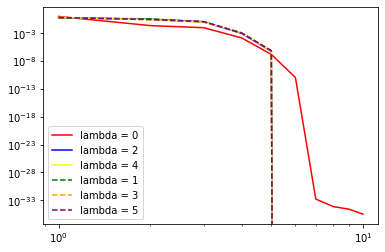

nu:  2


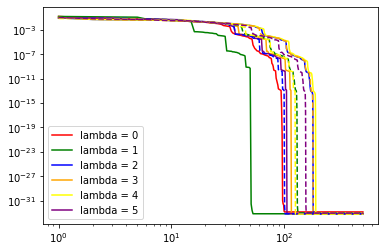

nu:  3


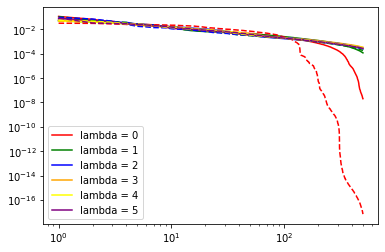

nu:  4


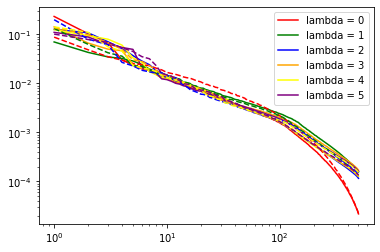

In [14]:
def proper_log_plot(array, *args, **kwargs):
    plt.plot(np.arange(len(array)) + 1, array, *args, **kwargs)

colors = ['r', 'g', 'b', 'orange', 'yellow', 'purple']

print("nu: ", 1)
for i in range(6):
    if (c_trans.initial_pca_ is not None):
        if (c_trans.initial_pca_.even_pca_.pcas_[i] is not None):
            proper_log_plot(c_trans.initial_pca_.even_pca_.pcas_[i].importances_, color = colors[i], label = "lambda = {}".format(i))


for i in range(6):
    if (c_trans.initial_pca_ is not None):
        if (c_trans.initial_pca_.odd_pca_.pcas_[i] is not None):
            proper_log_plot(c_trans.initial_pca_.odd_pca_.pcas_[i].importances_, '--', color = colors[i], label = "lambda = {}".format(i))

plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()
    
for nu in range(len(c_trans.blocks_)):
    print("nu: ", nu + 2)
    for i in range(6):
        if (c_trans.blocks_[nu].covariants_pca_ is not None):
            if (c_trans.blocks_[nu].covariants_pca_.even_pca_.pcas_[i] is not None):
                proper_log_plot(c_trans.blocks_[nu].covariants_pca_.even_pca_.pcas_[i].importances_, color = colors[i], label = "lambda = {}".format(i))
        
    
    for i in range(6):
        if (c_trans.blocks_[nu].covariants_pca_ is not None):
            if (c_trans.blocks_[nu].covariants_pca_.odd_pca_.pcas_[i] is not None):
                proper_log_plot(c_trans.blocks_[nu].covariants_pca_.odd_pca_.pcas_[i].importances_, '--', color = colors[i])
    
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.show()

In [15]:
intermediate_shapes = c_trans.get_intermediate_shapes()

In [16]:
for key in intermediate_shapes.keys():
    print(key, ':',  intermediate_shapes[key], end = '\n\n\n')

after initial transformer : [[10, 0, 10, 0, 10, 0], [0, 10, 0, 10, 0, 10]]


after initial pca : [[10, 0, 10, 0, 10, 0], [0, 10, 0, 10, 0, 10]]


block nu = 1 -> nu = 2 : {'after covariants expansioner': [[600, 500, 1300, 1000, 1400, 900], [0, 1000, 800, 1400, 1000, 1200]], 'after covariants purifier': [[600, 500, 1300, 1000, 1400, 900], [0, 1000, 800, 1400, 1000, 1200]], 'after covariants pca': [[500, 500, 500, 500, 500, 500], [0, 500, 500, 500, 500, 500]]}


block nu = 2 -> nu = 3 : {'after covariants expansioner': [[1050, 2062, 3447, 3610, 3909, 3166], [625, 2434, 3045, 3886, 3596, 3384]], 'after covariants purifier': [[1050, 2062, 3447, 3610, 3909, 3166], [625, 2434, 3045, 3886, 3596, 3384]], 'after covariants pca': [[500, 500, 500, 500, 500, 500], [500, 500, 500, 500, 500, 500]], 'after invariants expansioner': 10007, 'after invariants purifier': 10007}


block nu = 3 -> nu = 4 : {'after covariants expansioner': [[778, 2059, 2749, 3237, 3154, 2821], [796, 2013, 2871, 3165, 3257, 2